# Self-supervised Vision Transformer for Land Cover Classification and Segmentation: ResNet + Sentinel-2 Demo

Linus Scheibenreif, Joëlle Hanna, [University of St.Gallen,  School of Computer Science, AIML Lab](https://ics.unisg.ch/chair-aiml-borth/)


This notebook contains sample code for fine-tuning of the pretrained ResNet-50 backbones from this work. The two backbones, utilizing Sentinel-1 SAR data and Sentinel-2 multi-band imaging, can be used separately or in a combined way. In this example, we will fine-tune the ResNet-50 backbones to an image classification task, utilizing only Sentinel-2 data from the DFC2020 dataset. However, we would like to point out that the backbones are task agnostic and can be trained on any properly formatted Sentinel-1/2 dataset.

For further information, or to cite our work if you utilize this code, please refer to:

[Linus Scheibenreif, Joëlle Hanna, Michael Mommert, Damian Borth, *Self-Supervised Vision Transformers for Land-Cover Segmentation and Classification*, Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2022, pp. 1422-1431](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/html/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.html)

## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

First, start by cloning this repository:
```bash
git clone https://github.com/HSG-AIML/SSLTransformerRS.git
```

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:
```bash
pip install -r requirements.txt
```

In [1]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


<a id='dataset'></a>
## 2. Dataset


#### Download

Any Sentinel-1 data, Sentinel-2 data or a fusion of both could be used. In this demo, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using unimodal input here (Sentinel-2 only) but keep in mind that multimodal input (fusion of Sentinel-1 and Sentinel-2) can be used as well (you can see an example in the notebook `demo_swin_backbone.ipynb`)

#### Configure 

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [5]:
# Data configurations:
data_config = {
    'train_dir': 'data/data_disini', # path to the training directory,  
    'val_dir': 'data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [6]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [7]:
from dfc_dataset import DFCDataset

# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed'],
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

We can see how many examples are in each split by checking their length:

In [8]:
len(train_dataset), len(val_dataset)

(986, 5128)

We can also display some examples:

data/data_disini/ROIs0000_validation/s1_0/ROIs0000_validation_s1_0_p261.tif
data/data_disini/ROIs0000_validation/s2_0/ROIs0000_validation_s2_0_p261.tif
data/data_disini/ROIs0000_validation/lc_0/ROIs0000_validation_lc_0_p261.tif
data/data_disini/ROIs0000_validation/dfc_0/ROIs0000_validation_dfc_0_p261.tif


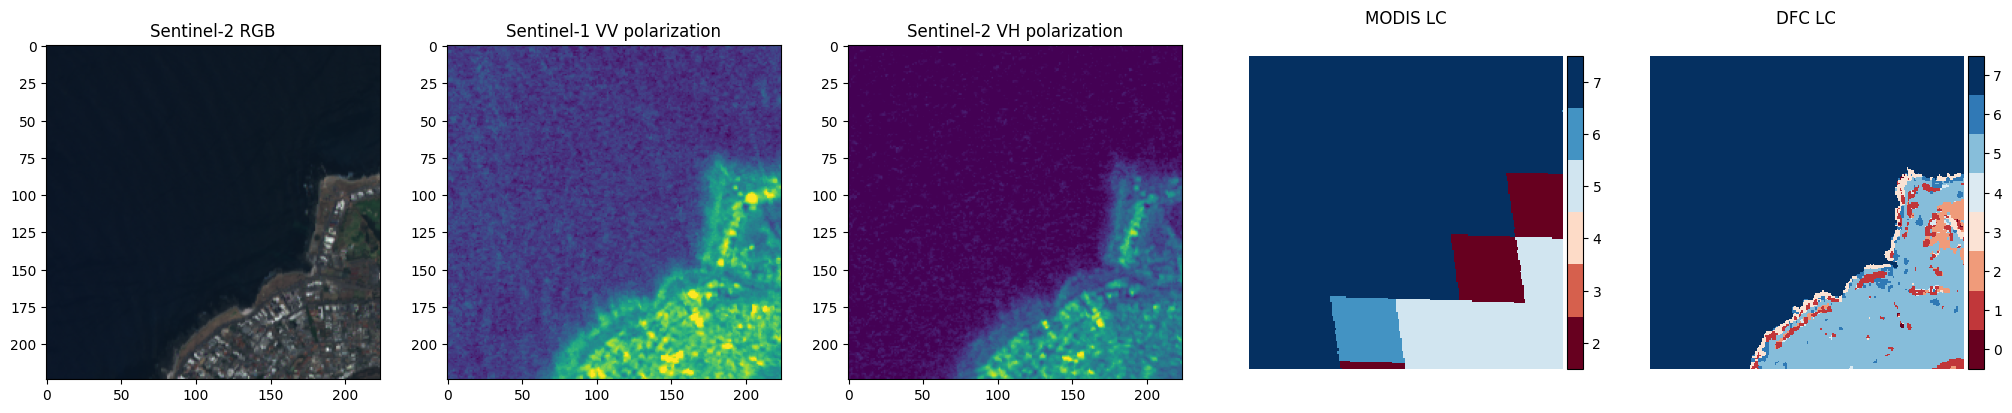

In [93]:
train_dataset.visualize_observation(120)

The plots show, from left to right: Sentinel-2 true color image, Sentinel-1 maps for the two different polarizations, a coarse MODIS LULC map and the high-resolution DFC2020 LULC map.

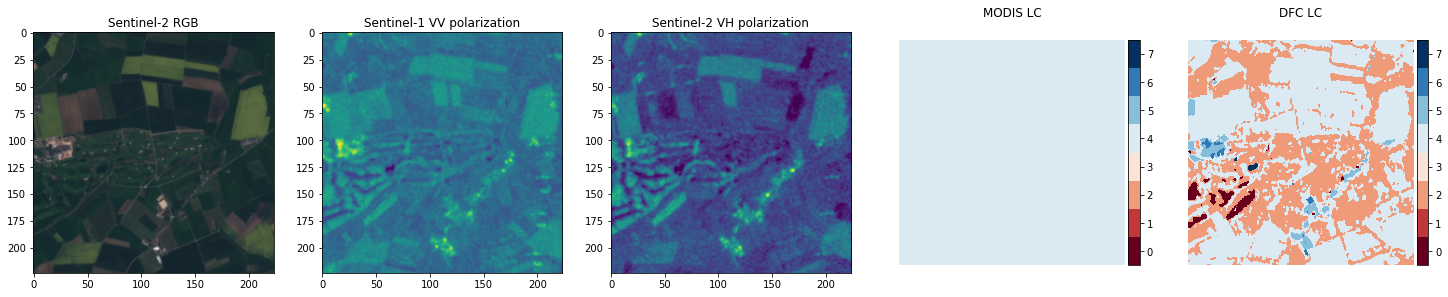

In [7]:
val_dataset.visualize_observation(67)

We define a correspondance of label and names:

In [8]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
} 

Our data is now ready to be used by the model. In the next section we load and configure the model. 

<a id='quickstart'></a>
## 3. Quick Start

#### Configure 

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [9]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1txqsNLUhIiQXRxflK_SMHn4y7Pp8o3mZ/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In [10]:
# path to the checkpoint
checkpoint = torch.load(
    "checkpoints/resnet50.pth"
) 

In [11]:
from utils import save_checkpoint_single_model, dotdictify

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

We create the downstream model head that will be trained. In this demo, we will train a classifier. Our classifier takes as input the pre-trained backbone (`resnet18` or `resnet50`) and the `out_dim` (number of classes).

In [12]:
import torchvision.models as models

class DoubleResNetSimCLRDownstream(torch.nn.Module):
    """concatenate outputs from two backbones and add one linear layer"""

    def __init__(self, base_model, out_dim):
        super(DoubleResNetSimCLRDownstream, self).__init__()

        self.resnet_dict = {"resnet18": models.resnet18,
                            "resnet50": models.resnet50,}
        

        self.backbone2 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        dim_mlp2 = self.backbone2.fc.in_features
        
        # If you are using multimodal data you can un-comment the following lines:
        # self.backbone1 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        # dim_mlp1 = self.backbone1.fc.in_features
        
        # add final linear layer
        self.fc = torch.nn.Linear(dim_mlp2, out_dim, bias=True)
        # self.fc = torch.nn.Linear(dim_mlp1 + dim_mlp2, out_dim, bias=True)

        # self.backbone1.fc = torch.nn.Identity()
        self.backbone2.fc = torch.nn.Identity()

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        x2 = self.backbone2(x["s2"])

        # If you are using multimodal data you can un-comment the following lines and comment z = self.fc(x2):
        # x1 = self.backbone1(x["s1"])
        # z = torch.cat([x1, x2], dim=1)
        # z = self.fc(z)
     
        z = self.fc(x2)
        
        return z
    
    def load_trained_state_dict(self, weights):
        """load the pre-trained backbone weights"""
        
        # remove the MLP projection heads
        for k in list(weights.keys()):
            if k.startswith(('backbone1.fc', 'backbone2.fc')):
                del weights[k]
        
        log = self.load_state_dict(weights, strict=False)
        assert log.missing_keys == ['fc.weight', 'fc.bias']
        
        # freeze all layers but the last fc
        for name, param in self.named_parameters():
            if name not in ['fc.weight', 'fc.bias']:
                param.requires_grad = False

In [13]:
base_model = "resnet50"
num_classes = 8

model = eval('DoubleResNetSimCLRDownstream')(base_model, num_classes)

# If you are using multimodal data you can un-comment the following lines:

# model.backbone1.conv1 = torch.nn.Conv2d(
#     train_config['s1_input_channels'],
#     64,
#     kernel_size=(7, 7),
#     stride=(2, 2),
#     padding=(3, 3),
#     bias=False,
# )

model.backbone2.conv1 = torch.nn.Conv2d(
    train_config['s2_input_channels'],
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

# load trained weights
model.load_trained_state_dict(checkpoint["state_dict"])

model = model.to(device)


Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss. 

In [14]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [15]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Finetuning


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want. 

In [16]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader 

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the classifier head:

In [18]:
from metrics import ClasswiseAccuracy
from validation_utils import validate_all

step = 0

# Training loop

for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = ClasswiseAccuracy(data_config['num_classes'])

    for idx, sample in enumerate(pbar):

        if "x" in sample.keys():
            if torch.isnan(sample["x"]).any():
                # some s1 scenes are known to have NaNs...
                continue
        else:
            if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                # some s1 scenes are known to have NaNs...
                continue
        
        # load input
        s2 = sample["s2"].to(device)
        img = {"s2": s2}
        
        # if you are using a unimodal dataset (s1 for example), you may un-comment the following lines:
        # s1 = sample["s1"].to(device)
        # img = {"s1": s1, "s2": s2}
        
        # load target
        y = sample[train_config['target']].long().to(device)
        
        # model output
        y_hat = model(img)
        
        # loss computation
        loss = criterion(y_hat, y)
        
        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # get prediction 
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()

    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_overall_accuracy": metrics.get_overall_accuracy(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
        }
    print(train_stats)

    if epoch % 2 == 0:  

        # Model Validation
        model.eval()
        pbar = tqdm(val_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = ClasswiseAccuracy(data_config['num_classes'])

        with torch.no_grad():
            for idx, sample in enumerate(pbar):
                if "x" in sample.keys():
                    if torch.isnan(sample["x"]).any():
                        # some s1 scenes are known to have NaNs...
                        continue
                else:
                    if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                        # some s1 scenes are known to have NaNs...
                        continue
                # load input
                s2 = sample["s2"].to(device)
                img = {"s2": s2}

                # if you are using a unimodal dataset (s1 for example), you may un-comment the following lines:
                # s1 = sample["s1"].to(device)
                # img = {"s1": s1, "s2": s2}

                # load target
                y = sample[train_config['target']].long().to(device)

                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction 
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()

            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_overall_accuracy": metrics.get_overall_accuracy(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
            }

            print(f"Epoch:{epoch}", val_stats)
            
            # Save model checkpoint every 2 epochs 
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "checkpoints/" + "-".join(["classifier", "epoch", str(epoch)]) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)


Epoch:0, Training Loss:1.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  3.95it/s]


{'train_loss': 1.2602483034133911, 'train_average_accuracy': 0.38970974033642813, 'train_overall_accuracy': 0.5730223123732252, 'train_accuracy_class_4': 0.31210191082802546, 'train_accuracy_class_6': 0.0, 'train_accuracy_class_3': 0.9444444444444444, 'train_accuracy_class_1': 0.0, 'train_accuracy_class_5': 0.6271186440677966, 'train_accuracy_class_2': 0.22549019607843138, 'train_accuracy_class_7': 0.7585227272727273, 'train_accuracy_class_0': 0.25}


Validation Loss:1.419: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:21<00:00,  3.93it/s]


Epoch:0 {'validation_loss': 1.4310413599014282, 'validation_average_accuracy': 0.3879317753957922, 'validation_overall_accuracy': 0.46801872074882994, 'validation_accuracy_class_7': 0.9875104079933389, 'validation_accuracy_class_0': 0.1896551724137931, 'validation_accuracy_class_4': 0.3189009159034138, 'validation_accuracy_class_5': 0.9611111111111111, 'validation_accuracy_class_1': 0.0, 'validation_accuracy_class_2': 0.02127659574468085, 'validation_accuracy_class_6': 0.0, 'validation_accuracy_class_3': 0.625}


Epoch:1, Training Loss:0.6669: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:18<00:00,  3.32it/s]


{'train_loss': 0.6668570637702942, 'train_average_accuracy': 0.5904366139501342, 'train_overall_accuracy': 0.7809330628803245, 'train_accuracy_class_3': 0.8176795580110497, 'train_accuracy_class_5': 0.8333333333333334, 'train_accuracy_class_7': 0.940677966101695, 'train_accuracy_class_4': 0.7908496732026143, 'train_accuracy_class_0': 0.76, 'train_accuracy_class_2': 0.580952380952381, 'train_accuracy_class_1': 0.0, 'train_accuracy_class_6': 0.0}


Epoch:2, Training Loss:0.5543: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.03it/s]


{'train_loss': 0.5542966723442078, 'train_average_accuracy': 0.6430713523697074, 'train_overall_accuracy': 0.8123732251521298, 'train_accuracy_class_7': 0.9714285714285714, 'train_accuracy_class_2': 0.63, 'train_accuracy_class_3': 0.7807486631016043, 'train_accuracy_class_0': 0.7532467532467533, 'train_accuracy_class_6': 0.0, 'train_accuracy_class_4': 0.8506493506493507, 'train_accuracy_class_5': 0.9152542372881356, 'train_accuracy_class_1': 0.24324324324324326}


Validation Loss:1.368: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:21<00:00,  3.95it/s]


Epoch:2 {'validation_loss': 1.3950722217559814, 'validation_average_accuracy': 0.39423183313054505, 'validation_overall_accuracy': 0.5120904836193447, 'validation_accuracy_class_7': 0.9924749163879598, 'validation_accuracy_class_0': 0.11584553928095873, 'validation_accuracy_class_4': 0.5777777777777777, 'validation_accuracy_class_5': 0.9496268656716418, 'validation_accuracy_class_1': 0.13261648745519714, 'validation_accuracy_class_2': 0.014084507042253521, 'validation_accuracy_class_6': 0.0, 'validation_accuracy_class_3': 0.37142857142857144}


Epoch:3, Training Loss:0.5156: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.25it/s]


{'train_loss': 0.515630841255188, 'train_average_accuracy': 0.6726293692352471, 'train_overall_accuracy': 0.8184584178498986, 'train_accuracy_class_4': 0.847682119205298, 'train_accuracy_class_2': 0.6372549019607843, 'train_accuracy_class_3': 0.8043478260869565, 'train_accuracy_class_0': 0.7307692307692307, 'train_accuracy_class_5': 0.8360655737704918, 'train_accuracy_class_7': 0.9659090909090909, 'train_accuracy_class_1': 0.42857142857142855, 'train_accuracy_class_6': 0.13043478260869565}


Epoch:4, Training Loss:0.4836: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]


{'train_loss': 0.48363831639289856, 'train_average_accuracy': 0.7117473665823897, 'train_overall_accuracy': 0.8275862068965517, 'train_accuracy_class_4': 0.8461538461538461, 'train_accuracy_class_0': 0.7564102564102564, 'train_accuracy_class_7': 0.943502824858757, 'train_accuracy_class_3': 0.797752808988764, 'train_accuracy_class_2': 0.6732673267326733, 'train_accuracy_class_5': 0.9016393442622951, 'train_accuracy_class_1': 0.6388888888888888, 'train_accuracy_class_6': 0.13636363636363635}


Validation Loss:1.3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:27<00:00,  3.66it/s]


Epoch:4 {'validation_loss': 1.3050440549850464, 'validation_average_accuracy': 0.4079065065735916, 'validation_overall_accuracy': 0.5438767550702028, 'validation_accuracy_class_7': 0.9908256880733946, 'validation_accuracy_class_0': 0.212, 'validation_accuracy_class_4': 0.5598678777869529, 'validation_accuracy_class_5': 0.9832089552238806, 'validation_accuracy_class_1': 0.23297491039426524, 'validation_accuracy_class_2': 0.013651877133105802, 'validation_accuracy_class_6': 0.012658227848101266, 'validation_accuracy_class_3': 0.25806451612903225}


You can evaluate the model on one example by creating an instance of the model, loading the corresponding checkpoint's weights saved during training, running it, and displaying the results:

Predicted class: Croplands
Ground-truth class:  Croplands


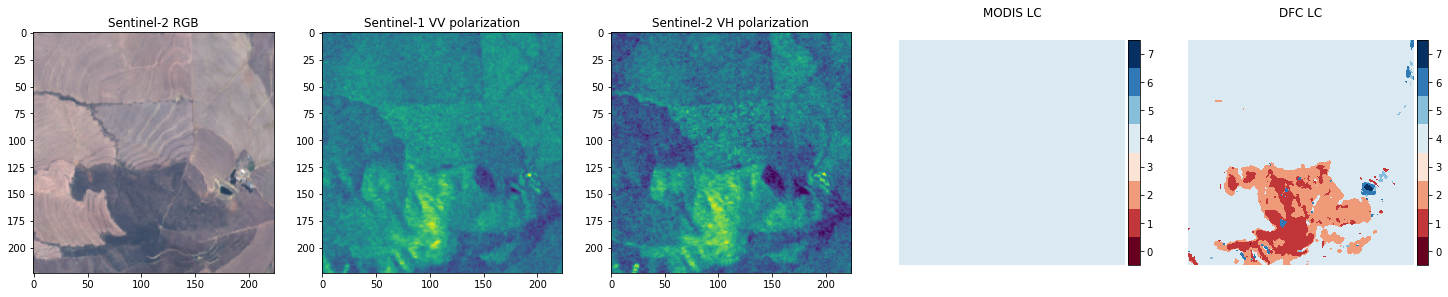

In [19]:
# create a new model's instance
base_model = "resnet50"
num_classes = 8

model = eval('DoubleResNetSimCLRDownstream')(base_model, num_classes)

model.backbone2.conv1 = torch.nn.Conv2d(
    train_config['s2_input_channels'],
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

# load checkpoints weights
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))
model.to(device)

# prepare input and feed it to model for evaluation
img = {"s2": torch.unsqueeze(val_dataset[2]['s2'].to(device), 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

# display predicted class:
print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')

# display ground-truth label:
print('Ground-truth class: ', DFC_map_clean[val_dataset[2][train_config['target']]])

# display image
val_dataset.visualize_observation(2)

Note that, although displayed here, Sentinel-1 data are disregarded in this demo. 